# Strain mapping of experimental Si/SiGe stacks using correlation approach

This notebook measures the strain fields of a experiemental 4D-STEM dataset which consists of alternating $Si / Si_{0.82}Ge_{0.18}$ multilayer stacks, on a $Si$ substrate, using correlation based approach in py4DSTEM library. The average thickness of the sample is approx. 110 nm as measured form the pure $Si$ region.

[Download the Si/SiGe multilayer experimental dataset here](https://drive.google.com/file/d/1-dXH_CzBEvbIcrzGADcoaPklDi8HH7z-/view?usp=sharing) <br>
[Download vacuum probe for the dataset here](https://drive.google.com/file/d/1Kz4IdsYMwaSu1G2igGF8mrVmACCXU-o2/view?usp=sharing)


### Acknowledgements

This tutorial was written by Joydeep Munshi (jmunshi@anl.gov) at Argonne National Lab and Colin Ophus (clophus@lbl.gov) at Berkeley Lab.

The experiments are performed by Steven Eric Zeltmann (steven.zeltmann@berkeley.edu).

### Version
Last updated on 2022-01-20 with py4DSTEM version 0.12.8 .



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Download the required database directly from google drive
from py4DSTEM.io import download_file_from_google_drive
#Change the 2nd argument of the function according to location of your local drive
download_file_from_google_drive("1-dXH_CzBEvbIcrzGADcoaPklDi8HH7z-", "./Si_SiGe_exp.h5")
download_file_from_google_drive("1Kz4IdsYMwaSu1G2igGF8mrVmACCXU-o2", "./Si_SiGe_probe.h5")
download_file_from_google_drive("1JXUI4Rlvewqd6_Ims6-dQaj3is-ilhV0", "./Si_SiGe_EELS_strain.mat")

File Already Exists
File Already Exists


In [3]:
#Required Libraries
import os
import h5py
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

import py4DSTEM
print('py4DSTEM: {}'.format(py4DSTEM.__version__))

py4DSTEM: 0.12.8


In [4]:
def image_clean(im, thresh=None):
    """
    # Remove bad points either due to x-rays or dead pixels

    Args:
        im (float):         Nx x Ny array containing image data 
        thresh (float):     intensity threshold.  If this is set to None (default), threshold will be set to
                            4*std of the image intensity.

    Returns:
        im_corr (float):    Nx x Ny array containting thresolded image
    """
    
    # If needed, find threshold value
    if thresh is None:
        thresh = 4.0 * np.std(im)
    
    # Calculate local 3x3 median image
    im_med = median_filter(
        im, 
        size=3,
        mode='nearest')
    
    # Pixel differences outside range
    sub = np.abs(im - im_med) > thresh
    
    # Generate corrected image    
    im_corr = im
    im_corr[sub] = im_med[sub]
    
    return im_corr

In [5]:
# File paths - output files will be augmented with the correct file extension
file_path_input_probe = "./Si_SiGe_probe.h5"
file_path_input_cbed = "./Si_SiGe_exp.h5"
file_path_output = './Si_SiGe_exp_analysis_corr.h5'

In [6]:
#Load the datacubes using py4DSTEM
dataset_probe = py4DSTEM.io.read(file_path_input_probe, data_id='datacube_0')
dataset_cbed = py4DSTEM.io.read(file_path_input_cbed, data_id='datacube_0')

In [7]:
#Generate the mean probe
probe_mean = np.mean(dataset_probe.data, axis=(0,1))

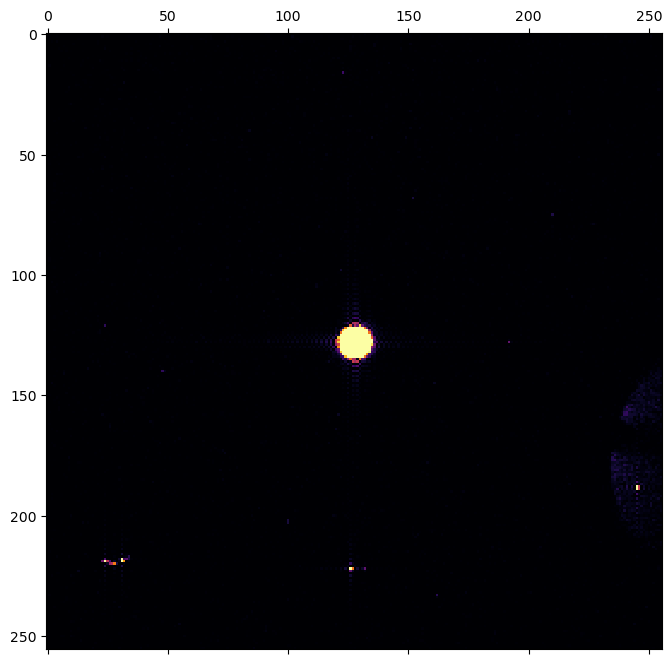

In [8]:
# Plot the mean Probe
py4DSTEM.visualize.show(
    probe_mean,
    clipvals='manual',
    min=0.0000002,
    max=0.0001,
    cmap='inferno')

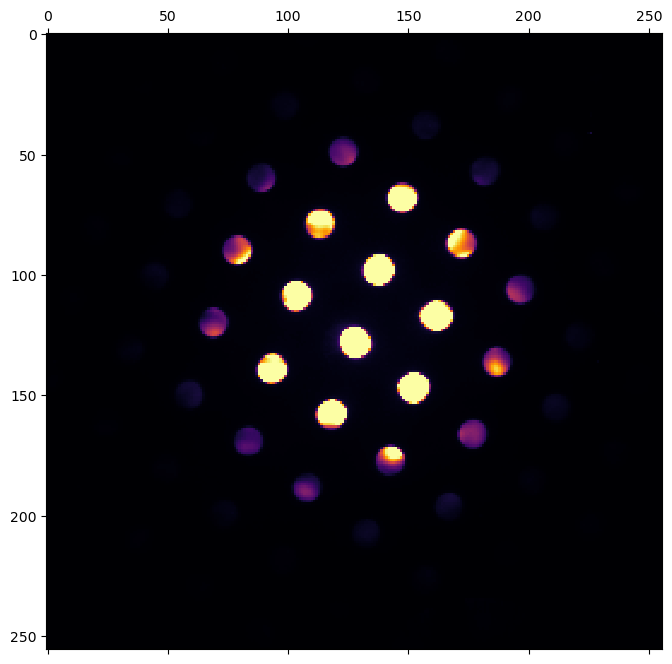

In [9]:
# Plot the mean diffraction
diffraction_pattern_mean = np.mean(dataset_cbed.data, axis=(0,1))
py4DSTEM.visualize.show(
    diffraction_pattern_mean,
    clipvals='manual',
    min=0.0000002,
    max=10,
    cmap='inferno')

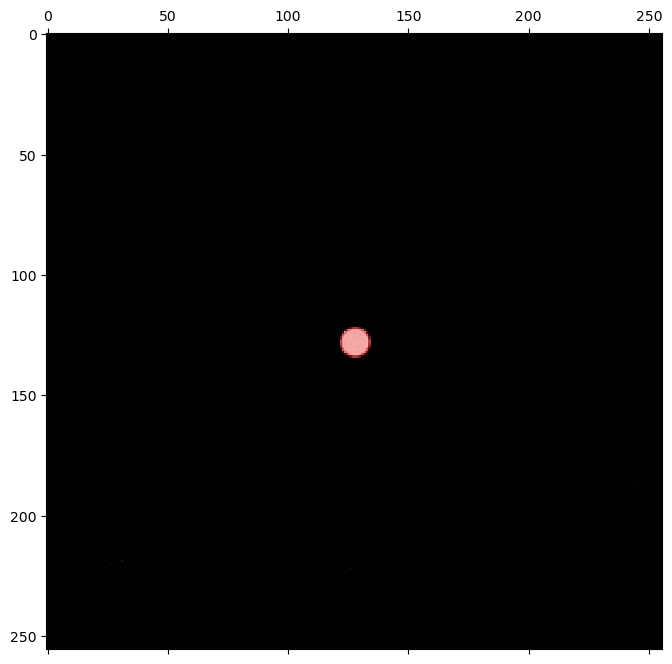

Estimated probe radius = 5.98 pixels
128.00045429732256 127.96523471873279


In [10]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, qx0, qy0 = py4DSTEM.process.calibration.get_probe_size(
    probe_mean,
    thresh_lower = 0.01,
    thresh_upper = 0.85)

#qx0, qy0 = np.argmax(diffraction_pattern_mean)//256,np.argmax(diffraction_pattern_mean)%256

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    probe_mean, 
    (qx0, qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')
print(qx0, qy0)

# Virtual image

In [12]:
# Next, create a BF virtual detector using the the center beam position (qxy0, qy0), and a virtual DF detector.
# The DF virtual detector can be set to all remaining pixels.
expand_BF = 4.0
image_BF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset_cbed, 
    qx0, qy0, 
    probe_semiangle + expand_BF)
image_DF = py4DSTEM.process.virtualimage.get_virtualimage(
    dataset_cbed, 
    qx0, qy0, 
    probe_semiangle + expand_BF,
    1e3)

100%|██████████| 10000/10000 [00:01<00:00, 7669.20it/s]


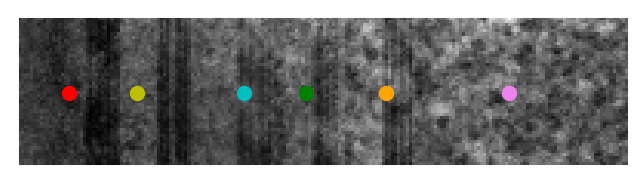

In [13]:
rxs = 25, 25, 25, 25, 25, 25
rys = 17, 39, 74, 94, 120, 160

fig, ax = py4DSTEM.visualize.show(image_BF,
                                  figsize=(16,2),
                                  bordercolor = 'w',
                                  cmap='gray',
                                  returnfig = True)
ax.scatter(rys[0], rxs[0], c='r', s=100)
ax.scatter(rys[1], rxs[1] , c='y', s=100)
ax.scatter(rys[2], rxs[2], c='c', s=100)
ax.scatter(rys[3], rxs[3], c='g', s=100)
ax.scatter(rys[4], rxs[4], c='orange', s=100)
ax.scatter(rys[5], rxs[5], c='violet', s=100)
#fig.savefig('./paper_figs/experiment_thick_BF.pdf', dpi=600)
plt.show()

# correlation

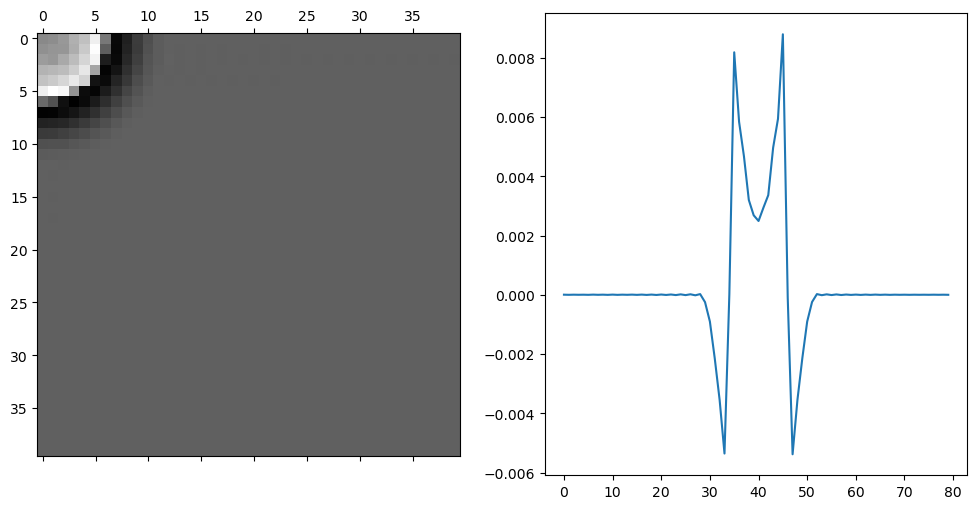

In [14]:
# Construct a probe template - we already have the probe array imported, so we start there.

# Shift probe to the origin and apply normalization by subtracting a sigmoid function.
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(
    probe_mean.data, 
    probe_semiangle * 0.0,                                            
    probe_semiangle * 2.0,)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_kernel, 
    R=40, 
    L=40, 
    W=2)

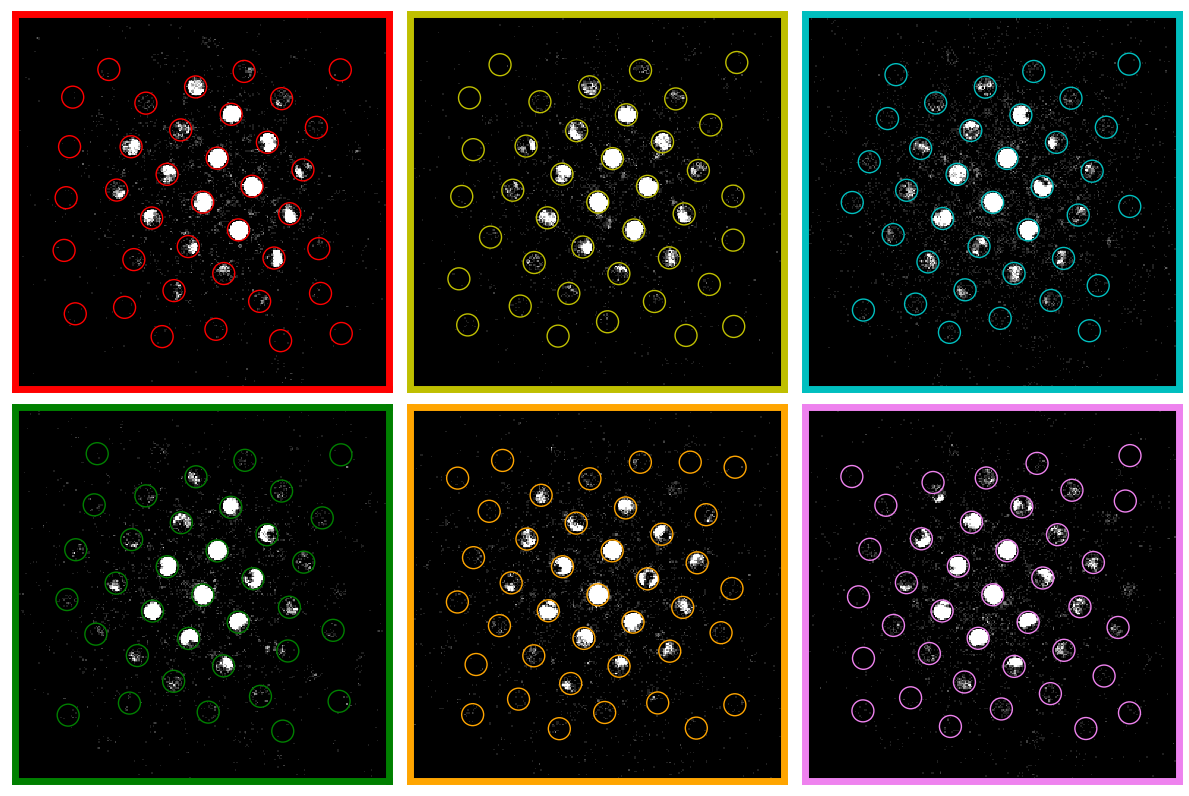

In [19]:
## Test hyperparameters on a few probe positions
#Lets visualize the diffraction patterns and the located disk positions
colors=['r','y','c','g','orange', 'violet']

dp0 = dataset_cbed.data[rxs[0],rys[0],:,:]
dp1 = dataset_cbed.data[rxs[1],rys[1],:,:]
dp2 = dataset_cbed.data[rxs[2],rys[2],:,:]
dp3 = dataset_cbed.data[rxs[3],rys[3],:,:]
dp4 = dataset_cbed.data[rxs[4],rys[4],:,:]
dp5 = dataset_cbed.data[rxs[5],rys[5],:,:]

# Run the disk detection on the selected DPs
corrPower=1.0
sigma=0
edgeBoundary= 32
minRelativeIntensity=0
minAbsIntensity=100
minPeakSpacing= 30
subpixel='multicorr'
upsample_factor=32
maxNumPeaks = 200


disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    dataset_cbed,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

fig, ax = py4DSTEM.visualize.show_image_grid(
    lambda i:[dp0,dp1,dp2,dp3,dp4, dp5][i],H=2,W=3,
    axsize=(4,4),
    clipvals='manual',
    min=0.0000002,
    max=8,
    get_bordercolor=lambda i:colors[i],                    
    get_x=lambda i:disks_selected[i].data['qx'],
    get_y=lambda i:disks_selected[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    open_circles=True,scale=250,
    returnfig= True)
#fig.savefig('./paper_figs/exp_thin_DP.pdf', dpi=600)
plt.show()

In [20]:
# Find all Bragg peaks
# WARNING - this is the "slow" step, though it will only take ~1 minute for a dataset of this size.
# Note the speed depends strongly on whether 'multicorr' (more accurate) or 'poly' (faster) is used.

bragg_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=dataset_cbed,
    probe=probe_kernel,                 
    corrPower=corrPower,                       
    sigma=sigma,                 
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,    
    upsample_factor=upsample_factor,
    CUDA =True
)

Finding Bragg Disks: 100%|██████████| 10.0k/10.0k [04:28<00:00, 37.3DP/s]

Analyzed 10000 diffraction patterns in 0h 4m 28s


# Fit a lattice

In [21]:
# Center the Bragg disk positions about the origin
bragg_peaks_centered = py4DSTEM.process.calibration.center_braggpeaks(
    bragg_peaks,
    qx0=qx0,
    qy0=qy0)

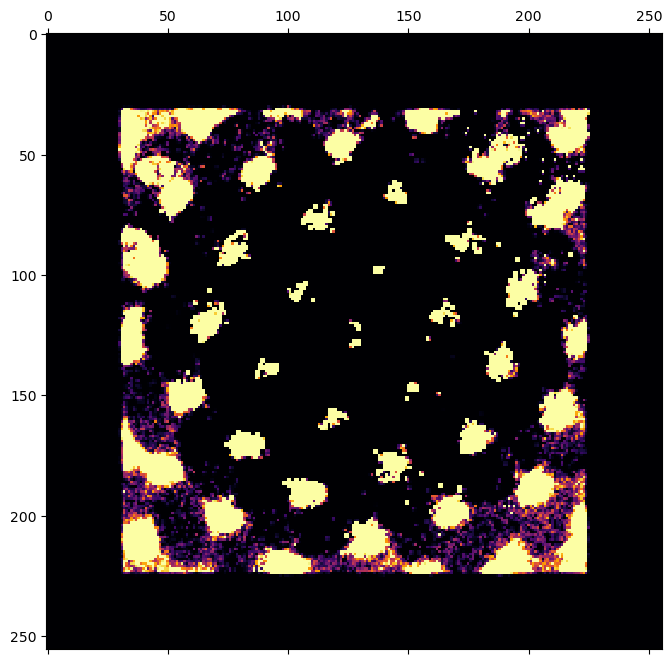

In [22]:
# Compute and plot Bragg vector map (BVM).

# Compute the Bragg vector map
bragg_vector_map = py4DSTEM.process.diskdetection.get_bvm(
    bragg_peaks_centered,
    256,
    256)

# plot the Bragg vector map
py4DSTEM.visualize.show(
    bragg_vector_map,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=1e-1)

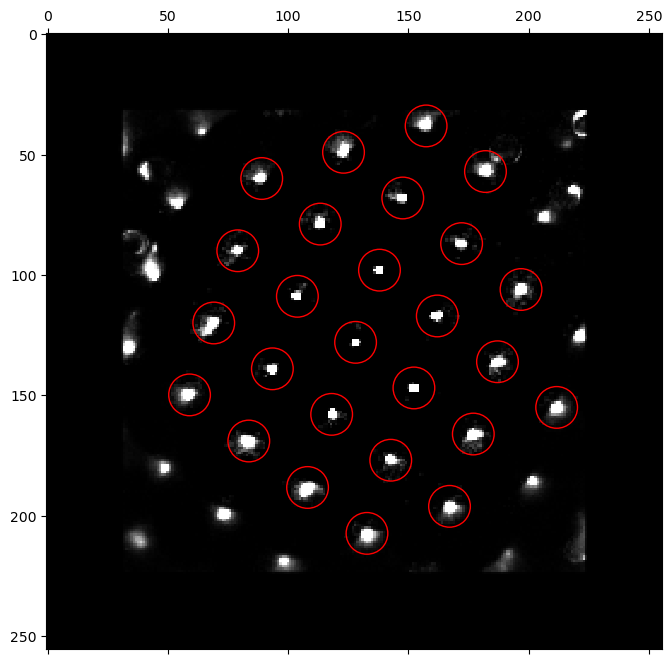

In [23]:
# Get all local maximum from the BVM, plot the candidate peaks
gx, gy, gI = py4DSTEM.process.utils.get_maxima_2D(
    bragg_vector_map,
    sigma=0, 
    edgeBoundary=10,
    minSpacing=16,
    minRelativeIntensity=0.001,
    relativeToPeak=0,
    maxNumPeaks=100,
    subpixel='multicorr'
)

# Plot the candidate lattice coordinates
py4DSTEM.visualize.show_points(
    bragg_vector_map,
    x=gx,
    y=gy,
    cmap='gray',
    clipvals='manual',
    min=0,
    max=10,
    open_circles=True,
    scale=900)

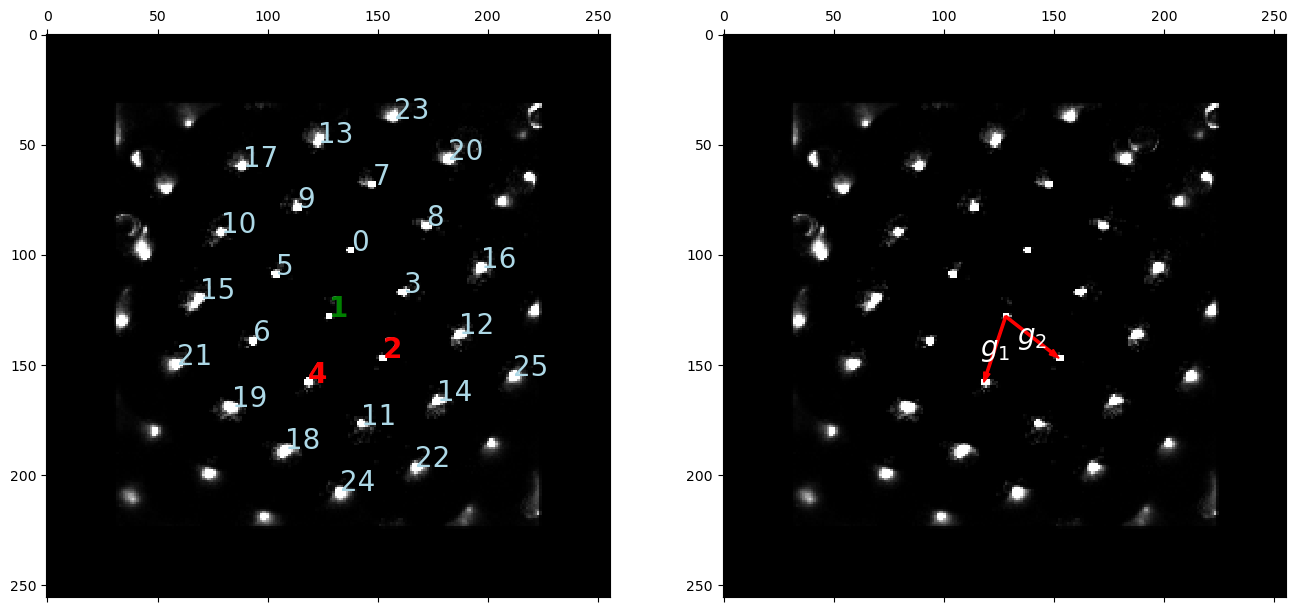

In [24]:
# Define peaks to use for computingstrain maps
index_0, index_g1, index_g2 = 1,4, 2

# Plot the selected lattice vectors - note they are in order of detected intensity
g1,g2 = py4DSTEM.visualize.select_lattice_vectors(
    bragg_vector_map,    
    figsize=(16,8),
    clipvals='manual',
    min=0,
    max=10,
    gx=gx,gy=gy,
    i0=index_0,
    i1=index_g1,
    i2=index_g2)

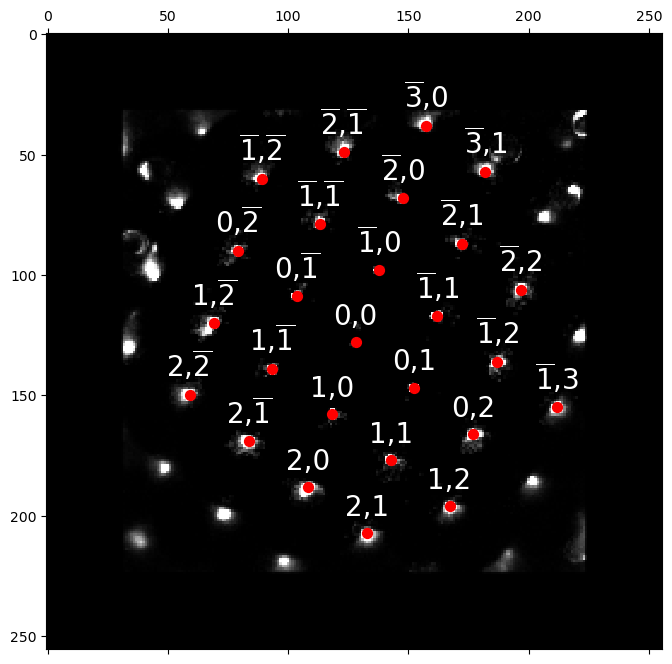

In [25]:
# Get indexing for all peaks, plot the indices overlaid onto the peaks
h, k, braggdirections = py4DSTEM.process.latticevectors.index_bragg_directions(
    qx0.mean(),qy0.mean(),
    gx,gy,
    g1,g2)
py4DSTEM.visualize.show_bragg_indexing(
    bragg_vector_map,
    clipvals='manual',
    min=0,
    max=10,
    braggdirections=braggdirections,
    points=True)

In [26]:
# maximum peak spacing from expected positions
max_peak_spacing = 8

# Add indices to the bragg_peaks PointListArray
bragg_peaks_indexed = py4DSTEM.process.latticevectors.add_indices_to_braggpeaks(
    bragg_peaks_centered,
    braggdirections,
    maxPeakSpacing=max_peak_spacing,
    qx_shift=qx0.mean(),
    qy_shift=qy0.mean())

In [27]:
# Fit the lattice in all diffraction images
g1g2_map = py4DSTEM.process.latticevectors.fit_lattice_vectors_all_DPs(bragg_peaks_indexed)

100%|██████████| 10000/10000 [00:01<00:00, 6756.31it/s]


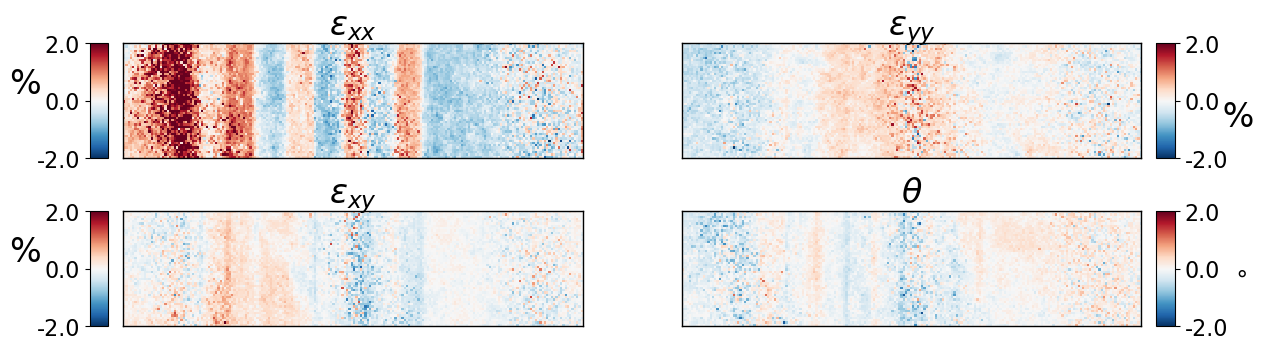

In [28]:
# Compute the strain using the median of the measured g1g2 as reference
strainmap_mediang1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_region(
    g1g2_map,
    mask=np.ones((dataset_cbed.R_Nx,dataset_cbed.R_Ny),dtype=bool))

# Rotate the lattice direction of the strain map 
# (pattern is rotated with respect to the scan direction)
g_reference = np.subtract(g1, g2)
#g_reference = g2
strainmap = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_mediang1g2,
    g_reference[0],
    g_reference[1])

mask = strainmap_mediang1g2.slices['mask'] == 1
# plot the 4 components of the strain tensor
py4DSTEM.visualize.show_strain(
    strainmap,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-2.0, 2.0],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(14,4))

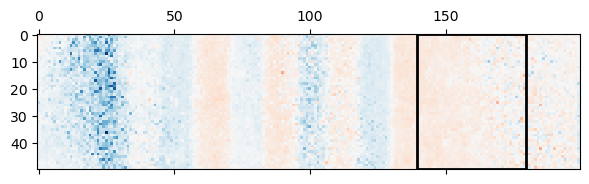

In [30]:
# Set the reference lattice to be the probe positions inside the substrate.

x0,xf = 0,50
y0,yf = 140, 180

py4DSTEM.visualize.show(
    strainmap_mediang1g2.slices['e_yy'],              
    mask=mask,
    figsize=(7, 20), 
    cmap='RdBu',
    clipvals='centered',
    min=0,
    rectangle={'lims':(x0,xf,y0,yf),'fill':False,'color':'k'})

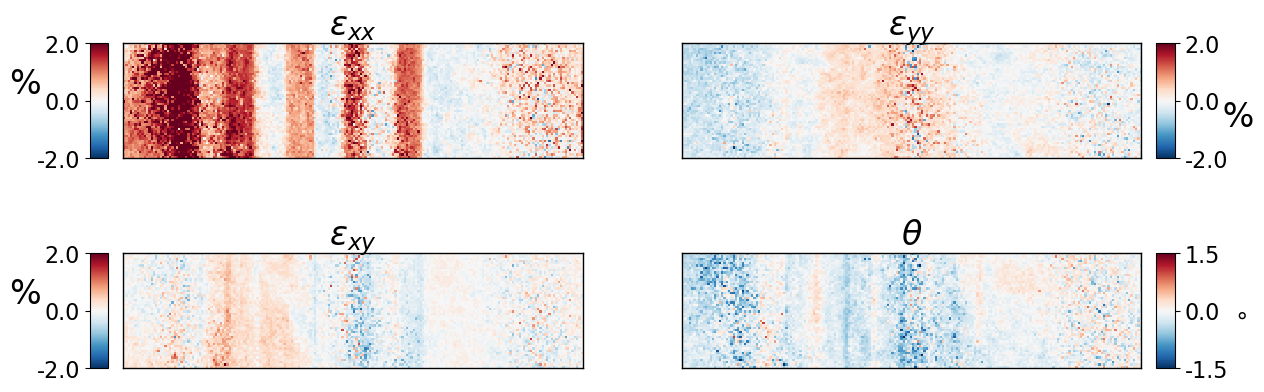

In [31]:
# Get new reference lattice vectors
mask = np.zeros((dataset_cbed.R_Nx,dataset_cbed.R_Ny),dtype=bool)
mask[x0:xf,y0:yf] = True
g1_ref,g2_ref = py4DSTEM.process.latticevectors.get_reference_g1g2(g1g2_map, mask)

# Recalculate the strain maps using the new reference lattice
strainmap_ROI_g1g2 = py4DSTEM.process.latticevectors.get_strain_from_reference_g1g2(
    g1g2_map,
    g1_ref,
    g2_ref)

# Rotate the lattice direction of the strain map 
strainmap_ROI = py4DSTEM.process.latticevectors.get_rotated_strain_map(
    strainmap_ROI_g1g2,
    g_reference[0],
    g_reference[1])

# plot the 4 components of the strain tensor
fig,axs = py4DSTEM.visualize.show_strain(
    strainmap_ROI,
    vrange_exx=[-2.0, 2.0],
    vrange_theta=[-1.5, 1.5],
    ticknumber=3,
    axes_plots=(),
    bkgrd=False,
    figsize=(14,5),
    returnfig=True)
#fig.savefig('./paper_figs/exp_thin_strain_corr.pdf', dpi=600)
plt.show()

# Plot line traces for the mean strain values

In [32]:
# Now load the experimental strain profile measured from the EELS composition map
eels_data = h5py.File('./Si_SiGe_EELS_strain.mat','r') 
imGe= np.asarray(eels_data['imGe'])
imSi= np.asarray(eels_data['imSi'])
strain_exp= 1.275*np.asarray(eels_data['strain'])
wGe= np.asarray(eels_data['wGe'])
wSi= np.asarray(eels_data['wSi'])

In [33]:
# Estimated strain profile from STEM-EELS
probe_step_x_ = np.arange(0,strainmap_ROI.data.shape[1])
strain_ideal_e_xx = np.mean(strain_exp, axis=0)
strain_ideal_e_yy = np.zeros_like(probe_step_x_)

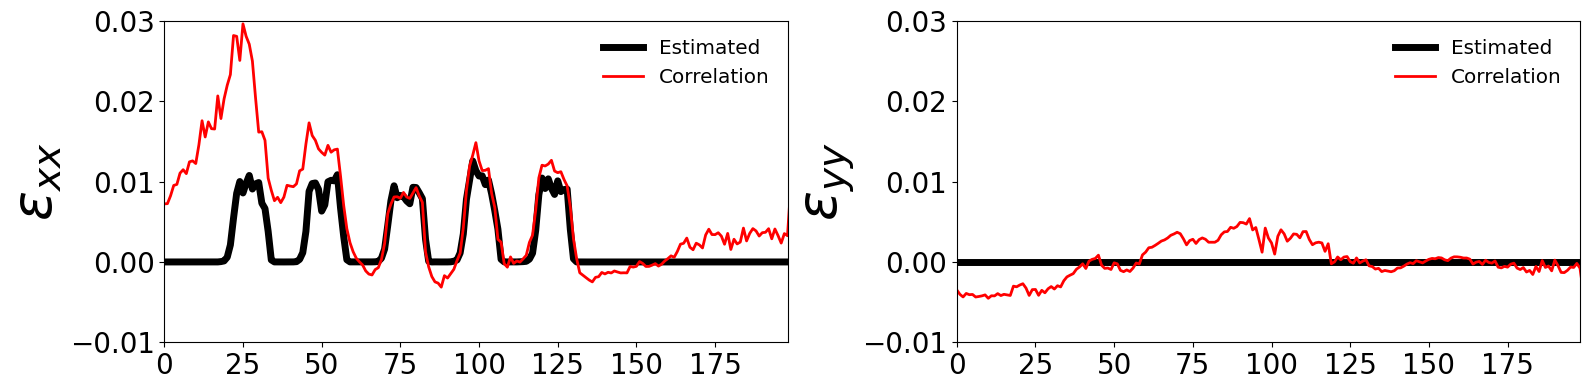

In [34]:
# Get mean E_xx and E_yy strain maps along the perpendicular to growth direction
strain_mean_e_xx_corr = np.mean(strainmap_ROI.slices['e_xx'],axis=0)
strain_mean_e_yy_corr = np.mean(strainmap_ROI.slices['e_yy'],axis=0)

# Plotting
fig, axs = plt.subplots(1,2,figsize=(16,4))

# strain along x direction
axs[0].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_xx, -3),
    color='k',
    linestyle='-', linewidth=5, label = 'Estimated');
axs[0].plot(
    probe_step_x_, 
    strain_mean_e_xx_corr,
    color='r', linewidth=2, label = 'Correlation')
axs[0].set_xlim(0,198)
axs[0].set_ylim(-0.01,0.03)

# strain along y direction
axs[1].plot(
    probe_step_x_, 
    np.roll(strain_ideal_e_yy,-10),
    color='k',
    linestyle='-',linewidth=5, label = 'Estimated');
axs[1].plot(
    probe_step_x_, 
    strain_mean_e_yy_corr,
    color='r', linewidth=2, label = 'Correlation')
axs[1].set_xlim(0,198)
axs[1].set_ylim(-0.01,0.03)
axs[0].legend(frameon=False, fontsize = 'x-large')
axs[1].legend(frameon=False, fontsize = 'x-large')
axs[0].locator_params(axis="y", nbins=4)
axs[1].locator_params(axis="y", nbins=4)
axs[0].locator_params(axis="x", nbins=8)
axs[1].locator_params(axis="x", nbins=8)
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
#ax.set_yticklabels(xlabels, fontsize= )
axs[0].set_ylabel(r'$\epsilon_{xx}$', fontsize = 40)
axs[1].set_ylabel(r'$\epsilon_{yy}$', fontsize = 40)
plt.tight_layout()
#fig.savefig('./paper_figs/strain_profile_exp_thin.pdf', dpi=600)
plt.show()

# Save data and strain maps

In [35]:
# Save all data in py4DSTEM format
# The diffraction space arrays we will save are:
diff = py4DSTEM.io.DiffractionSlice(
    data=np.dstack([diffraction_pattern_mean, 
                    probe_mean.data,
                    probe_kernel]),    
    slicelabels=['image_mean',
                 'probe',
                 'probe_kernel'],
    name='diffraction_images')

# The real space arrays we will save are:
real = py4DSTEM.io.RealSlice(
    data=np.dstack([image_BF, 
                    image_DF]),    
    slicelabels=['bright_field',
                 'dark_field'],
    name='real_space_images')

# Note we will also save the strain maps, but these are already stored as RealSlice objects.
# We will also store the center coordinates, estimated radius in pixels, strain reference direction,
# but most importantly - the Bragg disk positions and intensities (bragg_peaks_centered).
probe_fields = [("probe_semiangle",float),
              ("qx0", float),
              ("qy0", float)]
probe_data = py4DSTEM.io.PointList(coordinates=probe_fields)
probe_data.add_point((probe_semiangle, qx0, qy0))
probe_data.name = 'probe_data'

# Save all of the resulting data into a single .h5 file:
py4DSTEM.io.save(file_path_output,[diff,
                                      real,
                                      probe_data,
                                      strainmap_ROI,
                                      bragg_peaks_centered],
                                      overwrite=True)

  7%|▋         | 687/10000 [00:00<00:01, 6862.61it/s]

Saving DiffractionSlice 'diffraction_images'...
Saving RealSlice 'real_space_images'...
Saving PointList 'probe_data'...
Saving RealSlice 'strain_map_rotated'...
Saving PointListArray 'braggpeaks_centered'...


100%|██████████| 10000/10000 [00:01<00:00, 6914.90it/s]
